# Import libraries

In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats
from scipy.stats import entropy
import random
warnings.filterwarnings("ignore")

In [18]:
# Names of the environmental risks
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk",
    "three_square_risk": "Three localized Risks",
    "mid_mid_square_risk": "Mid square risk"
}

# Load genotype

In [19]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
name_risk

'blob_risk'

In [20]:
# PCA
nr_common_PCs = 24
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

In [21]:
complete

snps,CG34_AF_0.32671875,CG47_AF_0.27078125,CG81_AF_0.33859375,CG97_AF_0.33953125,CG117_AF_0.365,CG138_AF_0.3371875,CG140_AF_0.38703125,CG143_AF_0.4365625,CG167_AF_0.36015625,CG181_AF_0.3053125,...,VRG1931_AF_0.03625,VRG1939_AF_0.039375,VRG1945_AF_0.02859375,VRG1973_AF_0.02484375,VRG1980_AF_0.0459375,VRG1981_AF_0.02609375,VRG1986_AF_0.03125,VRG1989_AF_0.03859375,VRG1992_AF_0.0453125,VRG1999_AF_0.03125
0,0.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,0.0,1.0,-1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3196,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3197,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3198,0.0,1.0,0.0,0.0,-1.0,-1.0,1.0,-1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


# Load population

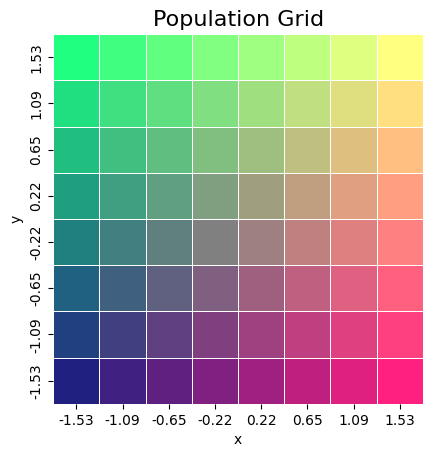

In [22]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Standardize the vector
std_dev = np.std(populations['x'])
mean = np.mean(populations['x'])
populations['x'] = np.round((populations['x'] - mean) / std_dev,2)

std_dev = np.std(populations['y'])
mean = np.mean(populations['y'])
populations['y'] = np.round((populations['y'] - mean) / std_dev,2)

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# environmental risk

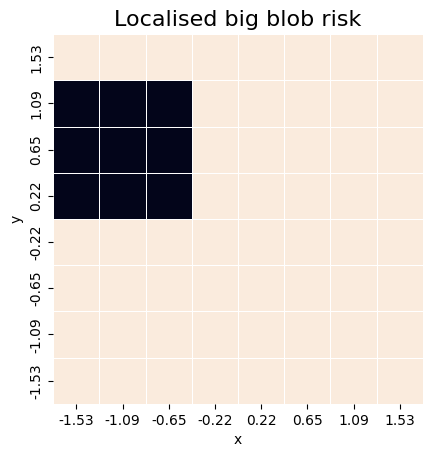

In [23]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")
populations[name_risk] = risk[name_risk]
df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title(f"{naming_dict[name_risk]}", fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

In [24]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])
precision = 0.05
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk]), precision))
# Calculate the standard deviation and mean
std_dev = np.std(y)
mean = np.mean(y)
# Standardize
y = (y - mean) / std_dev
risk['pheno'] = y
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

# SNP effect

In [25]:
def multi(arr, effectsize):
    return [1 * (num + 0.001) * effectsize for num in arr]

def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

In [26]:
effectsize = 1
numbers_af = [float(col.split('_AF_')[1]) for col in common.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in common.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_common = pd.DataFrame(data)
beta_common['maf'] = "common"

numbers_af = [float(col.split('_AF_')[1]) for col in rare.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in rare.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_rare = pd.DataFrame(data)
beta_rare['maf'] = "rare"

numbers_af = [float(col.split('_AF_')[1]) for col in very_rare.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in very_rare.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_very_rare = pd.DataFrame(data)
beta_very_rare['maf'] = "very rare"

betas = pd.concat([beta_common, beta_rare, beta_very_rare], ignore_index=True)

In [27]:
all_snps = list(complete.columns)
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(complete[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = complete.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / 0.001
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)
    std_dev = np.std(phenos_mono[snp])
    mean = np.mean(phenos_mono[snp])
    phenos_mono[snp] = (phenos_mono[snp] - mean) / std_dev


# Mixed

In [105]:
ratio_effect = 0.5
ratio_environment = 1-ratio_effect

In [106]:
for snp in list(phenos_mono.columns):
    phenos_mono[snp] = phenos_mono[snp]*ratio_effect + y*ratio_environment

In [107]:
correct_cov = risk[[name_risk]]

# Starting comparaisons

In [108]:
df_no_corr = manhattan_linear(complete, phenos_mono)
df_no_corr = pd.merge(df_no_corr, betas, on='snp')

Snp specific phenotype!
No Covs!


In [109]:
df_correct_corr = manhattan_linear(complete, phenos_mono, correct_cov)
df_correct_corr = pd.merge(df_correct_corr, betas, on='snp')

Snp specific phenotype!
Covs


In [110]:
pops = populations[['x','y']]
df_pops = manhattan_linear(complete, phenos_mono , pops)
df_pops = pd.merge(df_pops, betas, on='snp')

Snp specific phenotype!
Covs


In [111]:
true_p2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
true_twopqs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
true_q2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")

In [112]:
covariate_dictionary_true = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = true_p2s[snp] - true_q2s[snp]
    temp[f"{snp}_cov_2pq"] = true_twopqs[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary_true[snp] = temp

In [113]:
df_p_q_2pq_covs_via_true_pops = manhattan_linear(complete, phenos_mono, covariate_dictionary_true)
df_p_q_2pq_covs_via_true_pops = pd.merge(df_p_q_2pq_covs_via_true_pops, betas, on='snp')

Snp specific phenotype!
Dictionary Match!


In [114]:
df_PCs = manhattan_linear(complete, phenos_mono , PC_common[pc_columns])
df_PCs = pd.merge(df_PCs, betas, on='snp')

Snp specific phenotype!
Covs


In [115]:
p2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_truep2_via_estimated_pop.pkl")
twopq = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_true2pq_via_estimated_pop.pkl")
q2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_trueq2_via_estimated_pop.pkl")

In [116]:
covariate_dictionary_esti = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p2"] = p2[snp]
    temp[f"{snp}_cov_q2"] = q2[snp]
    temp[f"{snp}_cov_2pq"] = twopq[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary_esti[snp] = temp

In [117]:
df_abyss_p_q_2pq_covs_via_esti_pop = manhattan_linear(complete, phenos_mono, covariate_dictionary_esti)
df_abyss_p_q_2pq_covs_via_esti_pop = pd.merge(df_abyss_p_q_2pq_covs_via_esti_pop, betas, on='snp')

Snp specific phenotype!
Dictionary Match!


In [118]:
onehotpops = pd.get_dummies(populations[['populations']], columns=['populations']).astype(int)
df_pops_onehot = manhattan_linear(complete, phenos_mono , onehotpops)
df_pops_onehot = pd.merge(df_pops_onehot, betas, on='snp')

Snp specific phenotype!
Covs


In [119]:
# Plot

In [120]:
# Create QQ plot
df_bests = pd.DataFrame()
df_bests["-logP_no_corr"] = np.sort(df_no_corr['-logPs'])
df_bests["-logP_correct_corr"] = np.sort(df_correct_corr['-logPs'])
df_bests["-logP_true_pop"] = np.sort(df_pops['-logPs'])
df_bests["-logP_true_pop_onehot"] = np.sort(df_pops_onehot['-logPs'])
df_bests["-logP_abyss_via_true_pops"] = np.sort(df_p_q_2pq_covs_via_true_pops['-logPs'])
df_bests["-logP_abyss_pq2pq_via_esti_pops"] = np.sort(df_abyss_p_q_2pq_covs_via_esti_pop['-logPs'])


df_bests["-logP_PCs"] = np.sort(df_PCs['-logPs'])

# Find the maximum value in the DataFrame excluding inf and NaN
max_value = df_bests.replace([np.inf, -np.inf], np.nan).max().max()

# Replace inf values with the maximum value found
df_bests.replace([np.inf, -np.inf], max_value, inplace=True)

# Replace NaN values with the maximum value found
df_bests.fillna(max_value, inplace=True)
n = len(df_bests)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles))
df_bests['expected_logP'] = expected_logP

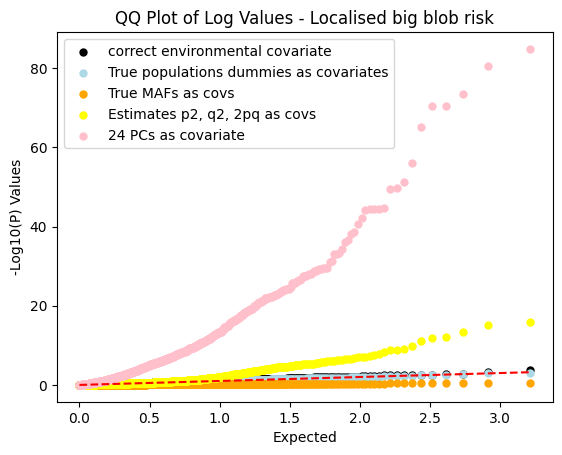

In [122]:
#sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_correct_corr', data=df_bests, color='black', label='correct environmental covariate', linewidth=0)

#sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations x,y axis as covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_pop_onehot', data=df_bests, color='lightblue', label='True populations dummies as covariates', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_abyss_via_true_pops', data=df_bests, color='orange', label='True MAFs as covs', linewidth=0)
sns.scatterplot(x='expected_logP', y='-logP_abyss_pq2pq_via_esti_pops', data=df_bests, color='yellow', label='Estimates p2, q2, 2pq as covs', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_PCs', data=df_bests, color='pink', label=f"{nr_common_PCs} PCs as covariate", linewidth=0)

# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"{path_plots}/qq_only_env_{name_risk}.png", dpi=100)
# Show plot
plt.show()